In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from KANConv import KAN_Convolutional_Layer, KANLinear

import KAN_Network

In [11]:
# Transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar MNIST y filtrar por dos clases
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)

mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:17<00:00, 1535534.63it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 120969.87it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2217295.35it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5156980.41it/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [3]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    # Set the model to training mode
    model.to(device)
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader, criterion):
    # Switch the model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += (target == predicted).sum().item()

            # Collect all targets and predictions for metric calculations
            all_targets.extend(target.view_as(predicted).cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Normalize test loss
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy, precision, recall, f1))

    return test_loss, accuracy, precision, recall, f1

## Modelos Comunes

In [4]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Capa convolucional, asumiendo una entrada con 1 canal (imagen en escala de grises)
        # y produciendo 16 canales de salida, con un kernel de tamaño 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, padding=1)
        
        # Capa de MaxPooling, utilizando un kernel de tamaño 2x2
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Capa lineal (Fully Connected)
        # Suponiendo una entrada de imagen de tamaño 28x28, después de conv y maxpool, será 14x14
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16 * 14 * 14, 10)

    def forward(self, x):
        # Aplicar la capa convolucional seguida de activación ReLU
        x = F.relu(self.conv1(x))
        # Aplicar max pooling
        x = self.maxpool(x)
        # Aplanar los datos
        x = self.flatten(x)
        # Capa lineal con 10 salidas
        x = self.fc(x)
        return x

class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()
        # Definir una sola capa lineal con 'input_features' entradas y 10 salidas
        self.linear = nn.Linear(28*28, 10)
        self.flatten = nn.Flatten()


    def forward(self, x):
        # Pasar los datos a través de la capa lineal
        x = self.flatten(x)
        x = self.linear(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Primera capa convolucional y segunda con el mismo padding y tamaño de kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding='same')

        # Segunda serie de capas convolucionales
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        # Capas de MaxPooling
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capas de Dropout
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)

        # Capa completamente conectada
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # 64 canales, tamaño de imagen reducido a 7x7
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Aplicar las primeras capas convolucionales y pooling
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout1(x)

        # Aplicar las segundas capas convolucionales y pooling
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = self.dropout2(x)

        # Aplanar los datos para la entrada a las capas densas
        x = torch.flatten(x, 1)  # Aplanar todo excepto el batch
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        # Aplicar softmax para obtener las probabilidades de las clases
        x = F.log_softmax(x, dim=1)
        return x


## Modelos Propios

In [25]:


class KAN_Convolutional_Network(nn.Module):
    def __init__(self,device: str = 'cpu'):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs = 5,
            kernel_size= (3,3),
            device = device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs = 5,
            kernel_size = (3,3),
            device = device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )
        
        self.flat = nn.Flatten() 
        
        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)
        # self.kan1 = KANLinear(
        #     625,
        #     10,
        #     grid_size=10,
        #     spline_order=3,
        #     scale_noise=0.01,
        #     scale_base=1,
        #     scale_spline=1,
        #     base_activation=nn.SiLU,
        #     grid_eps=0.02,
        #     grid_range=[0,1],
        # )

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        # x = self.kan1(x) 
        return x
    

In [24]:
# Instanciar el modelo
# model = SimpleCNN()
# model = SimpleLinear()
model = ConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


# Define loss
criterion = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 1
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader, criterion)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)
        scheduler.step()
        print('')
        print("lr: ", optimizer.param_groups[0]['lr'])
        print("test loss: ", test_loss)
        print("accuracy: ", accuracy)
        print("precision: ", precision)
        print("recall: ", recall)
        print("f1: ", f1)
        print('')


Training on cuda
Epoch: 1


100%|██████████| 938/938 [00:34<00:00, 27.18it/s]


Training set: Average loss: 0.202968

Test set: Average loss: 0.0007, Accuracy: 9863/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99


lr:  0.0008
test loss:  0.0006828907372968388
accuracy:  98.63
precision:  0.9864333734530139
recall:  0.9861776286826025
f1:  0.9862596558161332



In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = KAN_Convolutional_Network()
print("CKAN: ",count_parameters(model))

model2 = ConvNet()
print("ConvNet: ",count_parameters(model2))


CKAN:  163726
ConvNet:  887530


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KAN_Convolutional_Network(device = device)
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


# Define loss
criterion = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 1
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader, criterion)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)
        scheduler.step()
        print('')
        print("lr: ", optimizer.param_groups[0]['lr'])
        print("test loss: ", test_loss)
        print("accuracy: ", accuracy)
        print("precision: ", precision)
        print("recall: ", recall)
        print("f1: ", f1)
        print('')


Training on cuda
Epoch: 1


  4%|▎         | 33/938 [00:06<03:08,  4.81it/s]


KeyboardInterrupt: 

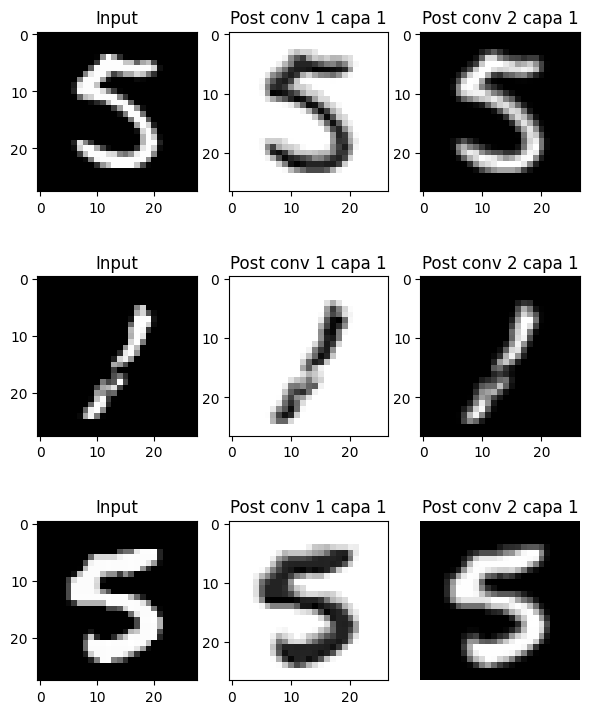

In [7]:
import matplotlib.pyplot as plt
rows =3
fig, ax  = plt.subplots(nrows = rows ,ncols = 3,figsize =(7,9))
with torch.no_grad():
    #figure.add_subplot(rows, cols, i)
    #  ax.title([label])
    for row in range(rows):
        plt.axis("off")
        sample_idx = torch.randint(len(mnist_test), size=(1,)).item()
        img, label = mnist_test[sample_idx]

        post_conv = model.conv1.forward(img.unsqueeze(0).to(device))
        #print(post_conv[0,0].shape)
        ax[row][0].imshow(img.squeeze(), cmap="gray")
        ax[row][0].set_title("Input")
        ax[row][1].imshow(post_conv[0,0].cpu(), cmap="gray")
        ax[row][1].set_title("Post conv 1 capa 1")
        ax[row][2].imshow(post_conv[0,1].cpu(), cmap="gray")
        ax[row][2].set_title("Post conv 2 capa 1")

torch.Size([1, 4, 12, 12])
torch.Size([1, 4, 12, 12])
torch.Size([1, 4, 12, 12])


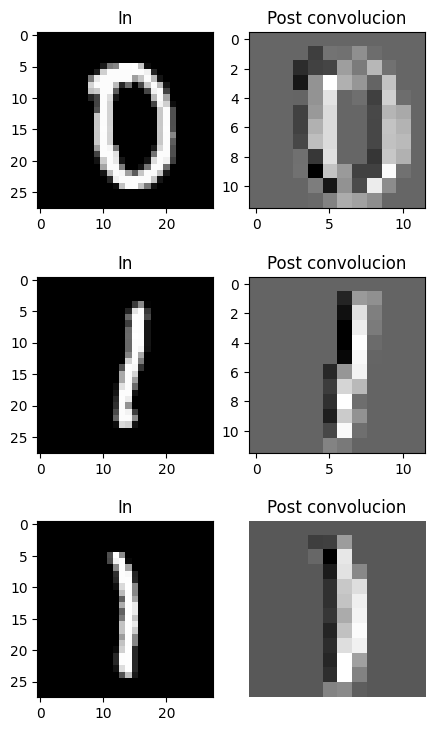

: 

In [8]:
import matplotlib.pyplot as plt
rows =3
fig, ax  = plt.subplots(nrows = rows ,ncols = 2,figsize =(5,9))
pool = nn.MaxPool2d(kernel_size=(2, 2))
with torch.no_grad():
    #figure.add_subplot(rows, cols, i)
    #  ax.title([label])
    for row in range(rows):
        plt.axis("off")
        sample_idx = torch.randint(len(mnist_test), size=(1,)).item()
        img, label = mnist_test[sample_idx]

        post_conv = pool(model.conv1.forward(img.unsqueeze(0).to(device)))
        post_conv = model.conv2.forward(post_conv) 
        
        print(post_conv.shape)
        ax[row][0].imshow(img.squeeze(), cmap="gray")
        ax[row][0].set_title("In")
        ax[row][1].imshow(post_conv[0,0].cpu(), cmap="gray")
        ax[row][1].set_title("Post convolucion")


In [18]:
def jack(score: tuple = (2,2)):
    print(score)

jack()

(2, 2)
